In [1]:
#coding=utf-8
import gdal
import os
import numpy as np
import argparse
from PIL import Image  
import cv2
import random
from tqdm import tqdm  
import time
import gdal
import seaborn as sns

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib
# data for training  
from Models import *
from Models.SegNet2In import *
from Models.utils import *
import argparse
import numpy as np 
from keras import backend as K 
from keras import *
from keras.applications import vgg16
from keras.layers import *
from keras.utils.np_utils import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.preprocessing.image import img_to_array
from keras.models import *
from keras import backend as K 
from sklearn.preprocessing import *

%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
matplotlib.use("Agg")

Using TensorFlow backend.
c:\users\sc\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\sc\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\sc\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:

In [2]:
from Evaluator import Evaluator 
cm=np.array([[3302928,54783],[13920,434626]])
ev=Evaluator(2,cm)
pa=ev.Pixel_Accuracy()
pac=ev.Pixel_Accuracy_Class()
miou=ev.Mean_Intersection_over_Union()
iou=ev.Class_IOU()
print( '\n Pixel_Accuracy:',pa,
      '\n Pixel_Accuracy_Class:',pac,
      '\n Mean_Intersection_over_Union:',miou,
      '\n Class_IOU:',iou)


 Pixel_Accuracy: 0.9819499839343481 
 Pixel_Accuracy_Class: 0.9763254071811163 
 Mean_Intersection_over_Union: 0.9215630066822049 
 Class_IOU: [0.97962321 0.8635028 ]


In [3]:
def plot_confusion_matrix(y_true, y_pred, labels):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    cmap = plt.cm.binary
    cm = confusion_matrix(y_true, y_pred)
    f, ax = plt.subplots(figsize=(6,5))
 
    sns.heatmap(cm, annot=True, ax=ax)
 
    print(cm)
    tick_marks = np.array(range(len(labels))) + 0.5
    np.set_printoptions(precision=2)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8), dpi=120)
    ind_array = np.arange(len(labels))
    x, y = np.meshgrid(ind_array, ind_array)
    intFlag = 0 # 标记在图片中对文字是整数型还是浮点型
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        #

        if (intFlag):
            c = cm[y_val][x_val]
            plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=18, va='center', ha='center')

        else:
            c = cm[y_val][x_val]
            if (c > 0.01):
                #这里是绘制数字，可以对数字大小和颜色进行修改
                plt.text(x_val, y_val, "%d" % (c,), color='red', fontsize=10, va='center', ha='center')
            else:
                plt.text(x_val, y_val, "%d" % (0,), color='red', fontsize=10, va='center', ha='center')
    if(intFlag):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
    else:
        plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.title('')
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('Index of True Classes')
    plt.xlabel('Index of Predict Classes')
    #plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

In [4]:
def predict(key,stride=256):
    method = {'SegNet2In_2':SegNet2In_2,
              'FCN32':FCN32,
              'SegNet0': SegNet0,
              'SegNet1': SegNet1,
              'SegNet2': SegNet2,
              'SegNet': SegNet}
    print("[INFO] loading network model...")
    try:
        model = load_model('D:\Python\seg-data/model/%s_model.h5' % key)
    except:
        model = method[key]() # 有自定义层时，不能直接加载模型
        model.load_weights('D:\Python\seg-data/model/%s_model.h5' % key)
    print('[INFO] model loaded')
    model.summary()
    image_size=stride
    TEST_SET=['2017']
    predir=r'D:\Python\seg-data\data_MB/'
    for n in range(len(TEST_SET)):
        tif_img = gdal.Open(predir+TEST_SET[n]+'.tif')
        tif_w = tif_img.RasterXSize #栅格矩阵的列数
        tif_h = tif_img.RasterYSize
        tif_data=tif_img.ReadAsArray(0,0,tif_w,tif_h)
        tif_d=tif_data.shape[0]
        tif_data=np.array(tif_data, dtype=float)
        image=cv2.merge(tif_data)
        h,w,_ = image.shape
        padding_h = (h//stride + 1) * stride 
        padding_w = (w//stride + 1) * stride
        padding_img = np.zeros((padding_h,padding_w,_))
        padding_img[0:h,0:w,:] = image[:,:,:]
        b1,b2,b3,b4=cv2.split(padding_img) 
        mask_whole = np.zeros((padding_h,padding_w))
        for i in range(padding_h//stride):
            for j in range(padding_w//stride):
                crop = padding_img[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:]
                ch,cw,_ = crop.shape
                #print(i,j)
                if (ch != 256 or cw != 256):
                    print ('invalid size!')
                    continue
                #plt.imshow(crop[:, :,0]/crop.max(), cmap='gray')
                #plt.show()
                crop = np.expand_dims(crop, axis=0)
                try:
                    pred = model.predict_classes(crop,verbose=0)
                    pred_prob = model.predict_proba(crop,verbose=1)#print ('trying\n')
                except AttributeError as e:
                    #layer_1 = K.function([model.layers[0].input], [model.layers[20].output])
                    #f1 = layer_1([crop])[-1]
                    #for _ in range(32):
                        #show_img = f1[:, :, :, _]
                        #show_img.shape = [149, 149]
                        #plt.rcParams['figure.dpi'] = 200
                        #plt.subplot(8, 4, _ + 1)
                        #plt.imshow(show_img[0], cmap='gray')
                        #print (show_img[0].shape)
                        #plt.axis('off')
                    #plt.show()
                    pred = model.predict(crop)
                    pred=np.argmax(pred,axis=2).astype(np.float) 
                    #print ('AttributeError\n')
                pred = pred.reshape(256,256)
                mask_whole[i*stride:i*stride+image_size,j*stride:j*stride+image_size] = pred[:,:]
                cv2.imwrite('./pre-img/pre'+str(i+1)+"-"+str(j+1)+'.png',pred*255)
        cv2.imwrite('.pre-img/pre'+str(n+1)+'.png',mask_whole[0:h,0:w]*255)
    y_true=cv2.imread('D:\Python\seg-data\data_MB/' + TEST_SET[0]+'.png',cv2.IMREAD_GRAYSCALE)
    #print(y_true.flatten().shape,mask_whole[0:h,0:w].flatten().shape)
    plot_confusion_matrix(y_true.flatten(), mask_whole[0:h,0:w].flatten(),[ 0,1])
    plt.imshow(mask_whole,cmap='gray')

In [5]:
def predict2input(key,stride=256):
    method = {'SegNet2In_2':SegNet2In_2}
    print("[INFO] loading network model...")
    try:
        model = load_model('D:\Python\seg-data/model/%s_model.h5' % key)
    except:
        model = method[key]() # 有自定义层时，不能直接加载模型
        model.load_weights('D:\Python\seg-data/model/%s_model.h5' % key)
    print('[INFO] model loaded')
    #print(model.get_weights()) #  [['test_10m_roi.tif'],['test_20m_roi.tif']],[['test_10m_roi.png'],['test_20m_roi.png']]
    image_size=stride
    TEST_SET_10=['test_10m_roi']
    TEST_SET_20=['test_20m_roi']
    predir=r'D:\Python\seg-data\data_MB/'
    for n in range(len(TEST_SET_20)):
        tif_img20 = gdal.Open(predir+TEST_SET_20[n]+'.tif')
        tif_w20 = tif_img20.RasterXSize #栅格矩阵的列数
        tif_h20 = tif_img20.RasterYSize
        tif_data20=tif_img20.ReadAsArray(0,0,tif_w20,tif_h20)
        tif_d20=tif_data20.shape[0]
        tif_data20=np.array(tif_data20, dtype=float)
        
        tif_img10 = gdal.Open(predir+TEST_SET_10[n]+'.tif')
        tif_w10 = tif_img10.RasterXSize #栅格矩阵的列数
        tif_h10 = tif_img10.RasterYSize
        tif_data10=tif_img10.ReadAsArray(0,0,tif_w10,tif_h10)
        tif_d10=tif_data10.shape[0]
        tif_data10=np.array(tif_data10, dtype=float)
        
        plt.imshow(tif_data10[0],cmap='gray')
        plt.show()
        plt.imshow(tif_data20[0],cmap='gray')
        plt.show()
        image10=cv2.merge(tif_data10)
        h10,w10,_10 = image10.shape
        image20=cv2.merge(tif_data20)
        h20,w20,_20 = image20.shape
        
        padding_h20 = (h20//(stride//2) + 1) * (stride//2)
        padding_w20 = (w20//(stride//2) + 1) * (stride//2)
        padding_img20 = np.zeros((padding_h20,padding_w20,_20))
        padding_img20[0:h20,0:w20,:] = image20[:,:,:]
        #mask_whole20 = np.zeros((padding_h20,padding_w20))
        
        padding_h10 = (h10//stride + 1) * stride 
        padding_w10 = (w10//stride + 1) * stride
        padding_img10 = np.zeros((padding_h10,padding_w10,_10))
        padding_img10[0:h10,0:w10,:] = image10[:,:,:]
        mask_whole10 = np.zeros((padding_h10,padding_w10))
        
        for i in range(padding_h10//stride):
            for j in range(padding_w10//stride):
                crop10 = padding_img10[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:]
                crop20 = padding_img20[i*128:i*128+128,j*128:j*128+128,:]
                ch10,cw10,_10 = crop10.shape
                if (ch10 != 256 or cw10 != 256):
                    print ('invalid size!')
                    continue
                crop10 = np.expand_dims(crop10, axis=0)
                crop20 = np.expand_dims(crop20, axis=0)
                crop=[crop10 , crop20]
                try:                    
                    pred = model.predict_classes(crop,verbose=0)
                    pred_prob = model.predict_proba(crop,verbose=1)
                    print ('[INFO]Trying\n')
                except AttributeError as e:
                    pred = model.predict(crop)
                    pred=np.argmax(model.predict(crop),axis=2).astype(np.float) 
                    print('[INFO]Except\n')
                
                pred = pred.reshape(256,256)
                mask_whole10[i*stride:i*stride+image_size,j*stride:j*stride+image_size] = pred[:,:]
                cv2.imwrite('./pre-img/pre'+str(i+1)+"-"+str(j+1)+'.png',pred*255)
    cv2.imwrite('./pre-img/pre.png',mask_whole10[0:h10,0:w10]*255)
    y_true=cv2.imread('D:\Python\seg-data\data_MB/' + TEST_SET_10[0]+'.png',cv2.IMREAD_GRAYSCALE)
    #print(y_true.flatten().shape,mask_whole[0:h,0:w].flatten().shape)
    plot_confusion_matrix(y_true.flatten(), mask_whole10[0:h10,0:w10].flatten(),[ 0,1])
    plt.imshow(mask_whole10*255,cmap='gray')

[INFO] loading network model...
[INFO] model loaded


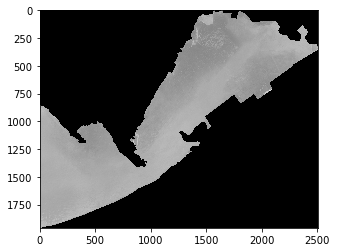

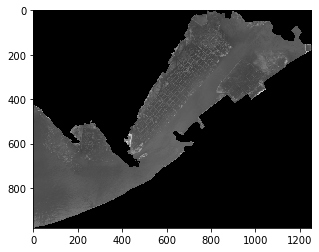

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0.,...

In [6]:
%matplotlib inline
predict2input(key='SegNet2In_2',stride=256)